## Yelp Users Data - Clustering & NLP

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
%matplotlib inline
inline_rc = dict(mpl.rcParams)

### 1. Read Data

In [2]:
# We only use the first 100,000 data in this assignment
users = []
with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json') as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= 100000:
            break
df = pd.DataFrame(users)
df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,...,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,...,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,...,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,...,1,0,0,1,16,57,80,80,25,5


In [3]:
# Measures of central tendency for given data
df.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,82.558470,211.546330,104.439670,133.010090,7.146770,3.798690,13.757830,1.73952,1.254500,1.005030,0.477890,8.135450,18.552510,18.771650,18.771650,7.094370,7.262320
std,201.292528,1353.683818,941.570493,1149.299821,38.507842,0.733975,216.503309,21.10247,27.541587,16.835325,10.529963,78.640364,215.653474,214.506727,214.506727,80.523743,188.018509
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,6.000000,1.000000,1.000000,0.000000,3.450000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,23.000000,5.000000,6.000000,1.000000,3.860000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,71.000000,85.000000,23.000000,27.000000,3.000000,4.250000,1.000000,0.00000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000
max,12390.000000,89792.000000,86122.000000,83915.000000,2964.000000,5.000000,34167.000000,3575.00000,5660.000000,2254.000000,2261.000000,7579.000000,14888.000000,19348.000000,19348.000000,8341.000000,39055.000000


In [4]:
# An overarching look at the missing data
# msno.matrix(df)

#### No significant missing Data - thats good!

### 2. Preprocessing
1. Drop columns not required
2. Make new colums from existing data 

**2.1 Drop columns name & user_id**
###### Could have dropped yelping_since and elite as well, but saved for later use

In [5]:
# Delete multiple columns from the df
df = df.drop(["user_id", "name"], axis=1)
# df.head()

#### 2.2 Add columns 
1. Column for number of friends
2. Column to keep count of number of years of elite status
3. Column to keep user since YR, and user since YRMO

2.2.1 Column for friend count

In [6]:
# Make column friend_count = number of friends
friend_count = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    friend_count[i] = len(df.loc[i, "friends"].split(","))
    
friend_count = pd.DataFrame(friend_count)
# print(friend_count)

In [7]:
# Add column friend count column to main db
df['friend_count'] = friend_count

# Drop column friends as not used again
df = df.drop(["friends"], axis=1)
df.head()

,review_count,yelping_since,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count
0,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017",5,4.03,2,0,0,0,0,1,1,1,1,2,0,99
1,33,2013-02-21 22:29:06,48,22,16,,4,3.63,1,0,0,0,0,0,0,1,1,0,0,1152
2,16,2013-10-04 00:16:10,28,8,10,,0,3.71,0,0,0,0,0,1,0,0,0,0,0,15
3,17,2014-05-22 15:57:30,30,4,14,,5,4.85,1,0,0,0,0,0,2,0,0,1,0,525
4,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018",39,4.08,28,1,0,0,1,16,57,80,80,25,5,231


2.2.2 Make column Elite Status Count (num of years), add it to db

In [8]:
elite_count = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    elite_count[i] = len(df.loc[i, "elite"].split(","))
    
elite_count = pd.DataFrame(elite_count)
# print(elite_count)
df['elite_count'] = elite_count  # Add column to df
df = df.drop(["elite"], axis=1) # Drop elite
df.head()

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count
0,95,2013-10-08 23:11:33,84,17,25,5,4.03,2,0,0,0,0,1,1,1,1,2,0,99,3
1,33,2013-02-21 22:29:06,48,22,16,4,3.63,1,0,0,0,0,0,0,1,1,0,0,1152,1
2,16,2013-10-04 00:16:10,28,8,10,0,3.71,0,0,0,0,0,1,0,0,0,0,0,15,1
3,17,2014-05-22 15:57:30,30,4,14,5,4.85,1,0,0,0,0,0,2,0,0,1,0,525,1
4,361,2013-10-23 07:02:50,1114,279,665,39,4.08,28,1,0,0,1,16,57,80,80,25,5,231,4


2.2.3 From yelping_since make columns for year and yearmonth (YRMO)

In [9]:
df['yelping_since'] = pd.to_datetime(df['yelping_since'])

df['yelp_since_YRMO'] = df['yelping_since'].map(lambda x: 100*x.year + x.month)
df['yelp_since_year'] = df['yelping_since'].dt.year

df.head()

,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,yelp_since_YRMO,yelp_since_year
0,95,2013-10-08 23:11:33,84,17,25,5,4.03,2,0,0,...,1,1,1,1,2,0,99,3,201310,2013
1,33,2013-02-21 22:29:06,48,22,16,4,3.63,1,0,0,...,0,0,1,1,0,0,1152,1,201302,2013
2,16,2013-10-04 00:16:10,28,8,10,0,3.71,0,0,0,...,1,0,0,0,0,0,15,1,201310,2013
3,17,2014-05-22 15:57:30,30,4,14,5,4.85,1,0,0,...,0,2,0,0,1,0,525,1,201405,2014
4,361,2013-10-23 07:02:50,1114,279,665,39,4.08,28,1,0,...,16,57,80,80,25,5,231,4,201310,2013


In [10]:
# Column to store whether compliment has been tagged
tagged_compliment = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    if sum(df.iloc[i, 7:18].values) > 0:
        tagged_compliment[i] = 1
        
tagged_compliment = pd.DataFrame(tagged_compliment)
df['tagged_compliment'] = tagged_compliment

### 3. Initail Data Analysis (IDA)

> 1. Time series analysis
> 2. Avg Stars Rating analysis
> 3. Feature Distributions

3.1 Time Series analysis of User Daata

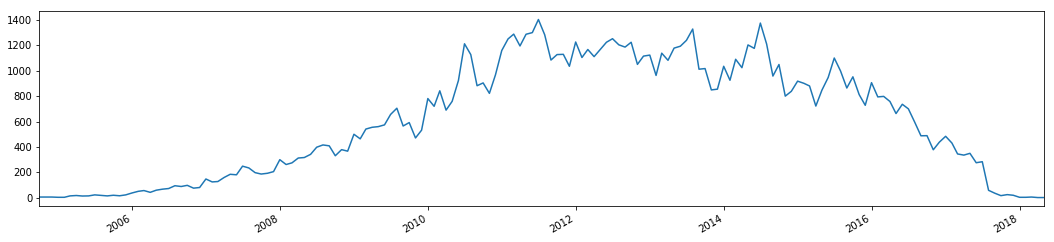

In [11]:
# Plot count vs yearmonth, to see the distribution
plt.figure(figsize=(18,4))
yrmo = pd.to_datetime(df['yelp_since_YRMO'], format='%Y%m')
yrmo = pd.DataFrame(yrmo)
yrmo.yelp_since_YRMO.value_counts().plot(kind='line')

Insight:
> For the given data max ids are form years 2010 to 2016

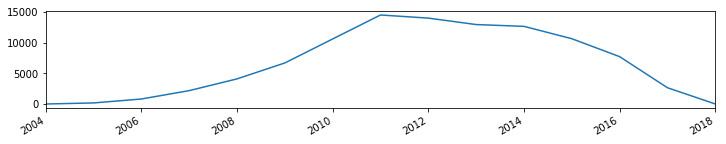

In [12]:
plt.figure(figsize=(12,2))
year = pd.to_datetime(df['yelp_since_year'], format='%Y')
year = pd.DataFrame(year)
year.yelp_since_year.value_counts().plot(kind='line')

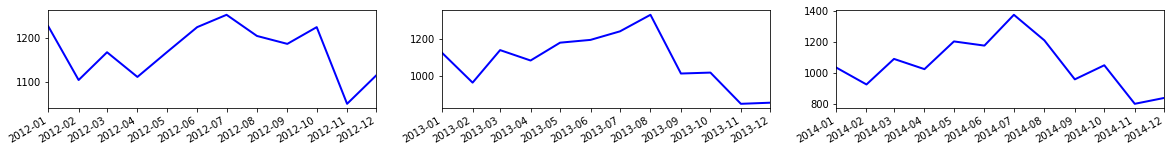

In [13]:
# Time Period 201201-201212 | 201301-201312 | 201401-201412
plt.figure(figsize=(20,2))
period_12 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201201, format='%Y%m')]
period_12 = period_12[period_12.yelp_since_YRMO <= pd.to_datetime(201212, format='%Y%m')]
period_12 = pd.to_datetime(period_12.yelp_since_YRMO, format='%Y%m')

period_13 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201301, format='%Y%m')]
period_13 = period_13[period_13.yelp_since_YRMO <= pd.to_datetime(201312, format='%Y%m')]
period_13 = pd.to_datetime(period_13.yelp_since_YRMO, format='%Y%m')

period_14 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201401, format='%Y%m')]
period_14 = period_14[period_14.yelp_since_YRMO <= pd.to_datetime(201412, format='%Y%m')]
period_14 = pd.to_datetime(period_14.yelp_since_YRMO, format='%Y%m')

plt.subplot(131)
period_12.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(132)
period_13.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(133)
period_14.value_counts().plot(kind='line', linewidth=2, color='b')
plt.show()

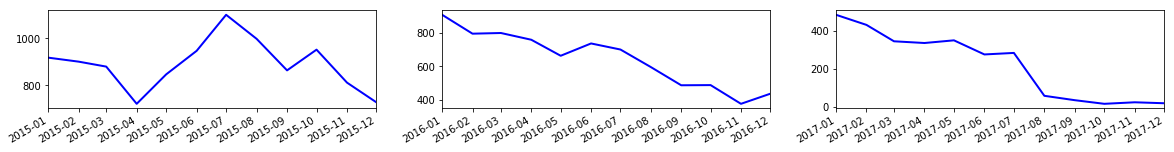

In [14]:
# Time Period 201501-201512 | 201601-201612 | 201701-201712
plt.figure(figsize=(20,2))
period_15 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201501, format='%Y%m')]
period_15 = period_15[period_15.yelp_since_YRMO <= pd.to_datetime(201512, format='%Y%m')]
period_15 = pd.to_datetime(period_15.yelp_since_YRMO, format='%Y%m')

period_16 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201601, format='%Y%m')]
period_16 = period_16[period_16.yelp_since_YRMO <= pd.to_datetime(201612, format='%Y%m')]
period_16 = pd.to_datetime(period_16.yelp_since_YRMO, format='%Y%m')

period_17 = yrmo[yrmo.yelp_since_YRMO >= pd.to_datetime(201701, format='%Y%m')]
period_17 = period_17[period_17.yelp_since_YRMO <= pd.to_datetime(201712, format='%Y%m')]
period_17 = pd.to_datetime(period_17.yelp_since_YRMO, format='%Y%m')

plt.subplot(131)
period_15.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(132)
period_16.value_counts().plot(kind='line', linewidth=2, color='b')
plt.subplot(133)
period_17.value_counts().plot(kind='line', linewidth=2, color='b')
plt.show()

Insights:
> 1. For majority of the years, we see max ids, or max usage in months May - August
> 2. Winter months, starting October usually see decline in new user or user usage
> 3. Less data (or users) available for 2016 and 2017, though years show similar peaks, the value of maximas and minimas are low comparitively

In [15]:
# Drop yelping_since column from df as not used again, and we already store lower granularity data in year & yrmo
df = df.drop(["yelping_since"], axis=1)

3.2 Avg Stars rating Analysis

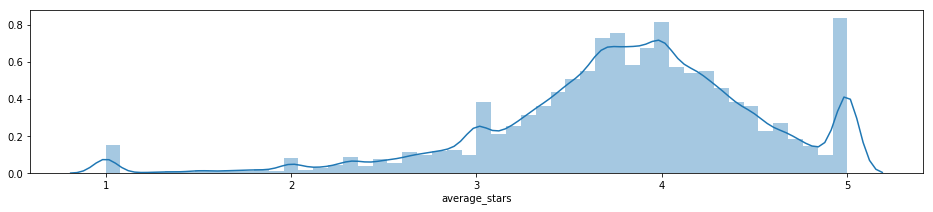

In [16]:
plt.figure(figsize=(16,3))
sns.distplot(df.average_stars)

In [17]:
raters_below_3 = len(df.loc[df.average_stars <= 3])
print("Users who rate <= 3 Avg Stars: {:0.02%}".format(raters_below_3/df.shape[0]))

Users who rate <= 3 Avg Stars: 12.53%


> * Ideal compariosn would be 3 way split, b/w Low-Med-High, but data is skewed towards people with high avg rating
> * value = 4 chosen as cut off, beacuse count of values with avg rating <= 3 is only ~12%

In [18]:
low_raters = len(df.loc[df.average_stars < 4])
high_raters = len(df.loc[df.average_stars >= 4])
print("Low Raters, <4 Avg Stars: {:0.02%}".format(low_raters/df.shape[0]))
print("High Raters >=4 Avg Stars: {:0.02%}".format(high_raters/df.shape[0]))

Low Raters, <4 Avg Stars: 58.18%
High Raters >=4 Avg Stars: 41.82%


Insights:
> 1.  Majority of people, >85% rate (or have avg stars) yelp listings above 3 stars
     *  The above could be deciphered in many ways, like data skewed towards higher avg raters,or
     *  Most of the people rate things higher on yelp, or
     *  People tend to only rate when they find something good (weak hypothesis)
> 2.  Very high raters (>4 avg ratings) are maginally lower ~42%
    

In [19]:
# Make a column raters, which is 1 for high raters (>=4 avg stars), and 0 for the rest (<4)

raters = [0 for _ in range(df.shape[0])]
for i in range(df.shape[0]):
    if df.loc[i,"average_stars"] >= 4:
        raters[i] = 1
#     elif float(3) <= df.loc[i,"average_stars"] < float(4):
#         rating[i] = "M"
#     else:
#         raters[i] = "H"
# Add column to main df
df['raters'] = raters

3.3 Distributions and corresponding analyses

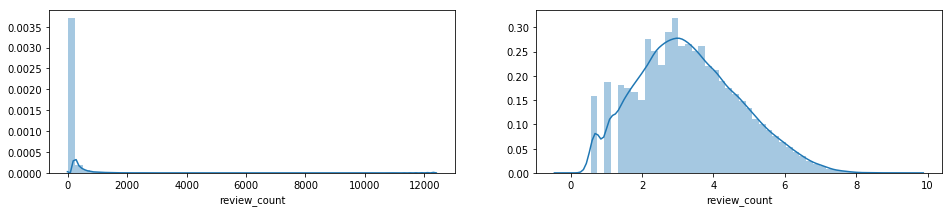

In [20]:
plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.review_count)

# Taking a Normal Distribution as review_count heavily skewed
plt.subplot(122)
sns.distplot(df.review_count.apply(np.log1p))

> 1. Majority of people of have written lower number of reviews
> 2. High number of reviews are very low <0.05% of populations/users (max reviewer has 12,390 reviews!)
> 3. From the people who actually review, high majority lie b/w 2-4 reviews

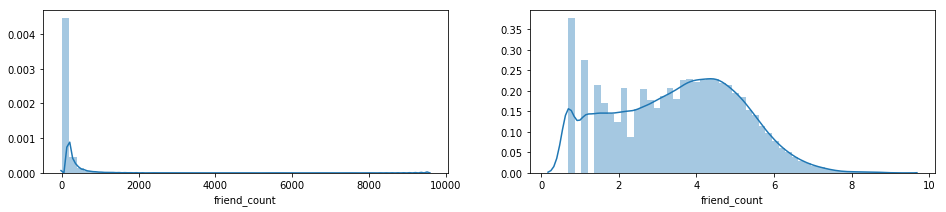

In [21]:
plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.friend_count)

# Taking a Normal Distribution as friend_count heavily skewed
plt.subplot(122)
sns.distplot(df.friend_count.apply(np.log1p))

> 1. Majority people don't have yelp friends (or haven't connected to to friends on yelp)
> 2. Those that have freinds on yelp, have usually between 2-5 freinds

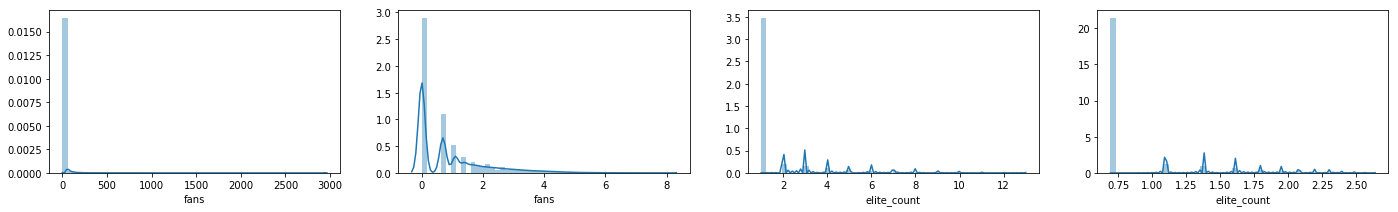

In [22]:
plt.figure(figsize=(24,3))

plt.subplot(141)
sns.distplot(df.fans)

# Taking a Normal Distribution as fans heavily skewed
plt.subplot(142)
sns.distplot(df.fans.apply(np.log1p))

plt.subplot(143)
sns.distplot(df.elite_count)

# Taking a Normal Distribution as elite_count heavily skewed
plt.subplot(144)
sns.distplot(df.elite_count.apply(np.log1p))

> 1. Very low number of people have have fans on yelp
> 2. Thos that have fans on yelp, usually have on avg 1-2 fans
> 3. Vast majority of people have never achieved elite status
> 4. Those who have been elite for multiple years, are also very few (elite status is definitely elusive!)

In [23]:
useful_reviews = len(df.loc[df.useful > 0])
print("People who leave useful reviews: {:0.0%}".format(useful_reviews/df.shape[0]))

People who leave useful reviews: 94%


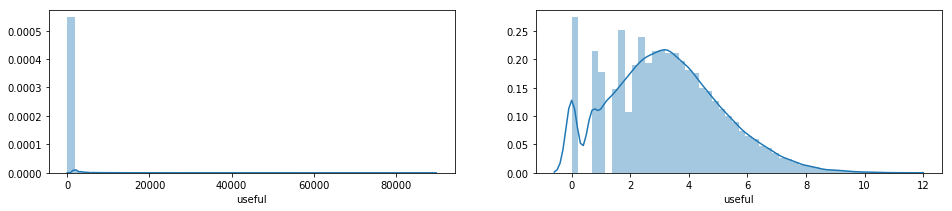

In [24]:
plt.figure(figsize=(16,3))
plt.subplot(121)
sns.distplot(df.useful)

# Taking a Normal Distribution as useful count heavily skewed
plt.subplot(122)
sns.distplot(df.useful.apply(np.log1p))

> 1. ~94% of people have left reviews tagged useful
> 2. However, people with high count of useful reviews is extremely low
> 3. Out of those 94%, most users tend to have only 2-6 reviews considered/tagged useful 
> 4. Metrics similar to ones for funny, and cool, so plots for those skipped here

*Much more indepth analyses perfomed in the EDA (Exploratory Data Analyses) script, all that skipped here to keep within the confines of this scipts' focus, which is Dimensionality Reduction and KMeans Clustering*

### 4. Scaling Feature Values
Scaling values for easy comparision, and for PCA
> * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
> * https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [25]:
from sklearn.preprocessing import StandardScaler

# Don't scale columns: yelp_since_year, yelp_since_YRMO, elite
features = ['review_count', 'useful', 'funny', 'cool', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'friend_count', 'elite_count', 'raters', 'tagged_compliment']
x = df.loc[:, features]
x = StandardScaler().fit_transform(x)

In [26]:
# Adding column names back to data, and converting ndarray back to datafram obj
df_train = pd.DataFrame(x, columns=features)
df_train.head()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,raters,tagged_compliment
0,0.061809,-0.094222,-0.092866,-0.093980,-0.055749,0.315149,-0.054308,-0.082432,-0.04555,-0.059698,...,-0.090736,-0.081393,-0.082849,-0.082849,-0.063266,-0.038626,-0.044453,1.033783,1.179564,0.720285
1,-0.246202,-0.120816,-0.087556,-0.101810,-0.081718,-0.229831,-0.058927,-0.082432,-0.04555,-0.059698,...,-0.103452,-0.086030,-0.082849,-0.082849,-0.088103,-0.038626,3.640265,-0.346066,-0.847771,0.720285
2,-0.330657,-0.135591,-0.102425,-0.107031,-0.185594,-0.120835,-0.063546,-0.082432,-0.04555,-0.059698,...,-0.090736,-0.086030,-0.087511,-0.087511,-0.088103,-0.038626,-0.338391,-0.346066,-0.847771,0.720285
3,-0.325689,-0.134113,-0.106673,-0.103551,-0.055749,1.432358,-0.058927,-0.082432,-0.04555,-0.059698,...,-0.103452,-0.076756,-0.087511,-0.087511,-0.075685,-0.038626,1.446230,-0.346066,1.179564,0.720285
4,1.383275,0.666668,0.185394,0.462884,0.827192,0.383272,0.065783,-0.035044,-0.04555,-0.059698,...,0.100007,0.178285,0.285439,0.285439,0.222366,-0.012032,0.417449,1.723708,1.179564,0.720285


In [27]:
# Eyebaling central tendency, and qc-ing scaled values
df_train.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,raters,tagged_compliment
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.296818e-15,-2.666357e-14,-3.880811e-14,-1.587219e-14,-1.718116e-14,7.069915e-15,-4.223611e-14,-5.944337e-14,-5.945904e-14,3.614579e-14,...,-9.450550e-14,1.307495e-14,2.886948e-14,2.886948e-14,5.306928e-14,8.340620e-15,2.893076e-15,3.147256e-14,-1.178049e-15,-1.410055e-13
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-4.101438e-01,-1.562753e-01,-1.109213e-01,-1.157320e-01,-1.855935e-01,-3.813076e+00,-6.354591e-02,-8.243247e-02,-4.554953e-02,-5.969799e-02,...,-1.034518e-01,-8.602970e-02,-8.751121e-02,-8.751121e-02,-8.810328e-02,-3.862575e-02,-3.873805e-01,-3.460662e-01,-8.477707e-01,-1.388339e+00
25%,-3.654325e-01,-1.518430e-01,-1.098592e-01,-1.148619e-01,-1.855935e-01,-4.750721e-01,-6.354591e-02,-8.243247e-02,-4.554953e-02,-5.969799e-02,...,-1.034518e-01,-8.602970e-02,-8.751121e-02,-8.751121e-02,-8.810328e-02,-3.862575e-02,-3.628857e-01,-3.460662e-01,-8.477707e-01,-1.388339e+00
50%,-2.909137e-01,-1.392846e-01,-1.056110e-01,-1.105114e-01,-1.596246e-01,8.353251e-02,-6.354591e-02,-8.243247e-02,-4.554953e-02,-5.969799e-02,...,-1.034518e-01,-8.602970e-02,-8.751121e-02,-8.751121e-02,-8.810328e-02,-3.862575e-02,-2.614073e-01,-3.460662e-01,-8.477707e-01,7.202850e-01
75%,-5.742154e-02,-9.348340e-02,-8.649387e-02,-9.223931e-02,-1.076869e-01,6.148882e-01,-5.892702e-02,-8.243247e-02,-4.554953e-02,-5.969799e-02,...,-7.801948e-02,-7.675551e-02,-7.818745e-02,-7.818745e-02,-7.568452e-02,-3.862575e-02,4.536297e-03,-3.460662e-01,1.179564e+00,7.202850e-01
max,6.114237e+01,6.617565e+01,9.135587e+01,7.289865e+01,7.678613e+01,1.636726e+00,1.577501e+02,1.693299e+02,2.054629e+02,1.338261e+02,...,9.627247e+01,6.895100e+01,9.011058e+01,9.011058e+01,1.034968e+02,2.076813e+02,3.307602e+01,7.933030e+00,1.179564e+00,7.202850e-01


### 5. Measuring simalrity between fetaures

Comparing covariance for scaled values and correlations for unscaled original df

In [28]:
# Covariance matrix of scaled data
cov = df_train.cov()
cov.style.background_gradient(cmap='coolwarm').set_precision(2)

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,raters,tagged_compliment
review_count,1,0.65,0.54,0.57,0.63,-0.0081,0.29,0.33,0.21,0.26,0.23,0.44,0.41,0.4,0.4,0.4,0.2,0.5,0.68,-0.12,0.25
useful,0.65,1,0.97,0.99,0.81,-0.00086,0.64,0.64,0.45,0.47,0.39,0.76,0.74,0.79,0.79,0.79,0.58,0.61,0.4,-0.049,0.11
funny,0.54,0.97,1,0.98,0.76,-0.00078,0.68,0.67,0.48,0.5,0.41,0.78,0.74,0.82,0.82,0.82,0.62,0.55,0.32,-0.038,0.078
cool,0.57,0.99,0.98,1,0.77,0.0054,0.67,0.65,0.46,0.48,0.39,0.76,0.73,0.81,0.81,0.8,0.6,0.58,0.34,-0.032,0.082
fans,0.63,0.81,0.76,0.77,1,0.011,0.56,0.52,0.37,0.49,0.37,0.72,0.74,0.67,0.67,0.65,0.45,0.75,0.46,-0.04,0.13
average_stars,-0.0081,-0.00086,-0.00078,0.0054,0.011,1,0.0045,-0.00067,0.00049,0.0023,-0.001,0.00061,0.0056,0.0048,0.0048,0.0021,0.0034,0.044,0.0089,0.72,-0.027
compliment_hot,0.29,0.64,0.68,0.67,0.56,0.0045,1,0.71,0.6,0.69,0.47,0.79,0.71,0.89,0.89,0.78,0.79,0.36,0.22,-0.016,0.046
compliment_more,0.33,0.64,0.67,0.65,0.52,-0.00067,0.71,1,0.93,0.77,0.85,0.83,0.67,0.77,0.77,0.85,0.68,0.36,0.23,-0.029,0.059
compliment_profile,0.21,0.45,0.48,0.46,0.37,0.00049,0.6,0.93,1,0.79,0.91,0.7,0.55,0.64,0.64,0.73,0.61,0.25,0.15,-0.017,0.033
compliment_cute,0.26,0.47,0.5,0.48,0.49,0.0023,0.69,0.77,0.79,1,0.78,0.68,0.56,0.66,0.66,0.66,0.57,0.33,0.2,-0.019,0.043


In [29]:
# Correlation matrix of unscaled original data which includes, elite count, yrmo features etc
# Idea is to see which features are correlated and can be combined (PCA) together to build a hypothesis/cluster

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,elite_count,yelp_since_YRMO,yelp_since_year,tagged_compliment,raters
review_count,1,0.65,0.54,0.57,0.63,-0.0081,0.29,0.33,0.21,0.26,0.23,0.44,0.41,0.4,0.4,0.4,0.2,0.5,0.68,-0.29,-0.29,0.25,-0.12
useful,0.65,1,0.97,0.99,0.81,-0.00086,0.64,0.64,0.45,0.47,0.39,0.76,0.74,0.79,0.79,0.79,0.58,0.61,0.4,-0.14,-0.14,0.11,-0.049
funny,0.54,0.97,1,0.98,0.76,-0.00078,0.68,0.67,0.48,0.5,0.41,0.78,0.74,0.82,0.82,0.82,0.62,0.55,0.32,-0.11,-0.11,0.078,-0.038
cool,0.57,0.99,0.98,1,0.77,0.0054,0.67,0.65,0.46,0.48,0.39,0.76,0.73,0.81,0.81,0.8,0.6,0.58,0.34,-0.11,-0.11,0.082,-0.032
fans,0.63,0.81,0.76,0.77,1,0.011,0.56,0.52,0.37,0.49,0.37,0.72,0.74,0.67,0.67,0.65,0.45,0.75,0.46,-0.17,-0.17,0.13,-0.04
average_stars,-0.0081,-0.00086,-0.00078,0.0054,0.011,1,0.0045,-0.00067,0.00049,0.0023,-0.001,0.00061,0.0056,0.0048,0.0048,0.0021,0.0034,0.044,0.0089,0.023,0.023,-0.027,0.72
compliment_hot,0.29,0.64,0.68,0.67,0.56,0.0045,1,0.71,0.6,0.69,0.47,0.79,0.71,0.89,0.89,0.78,0.79,0.36,0.22,-0.082,-0.081,0.046,-0.016
compliment_more,0.33,0.64,0.67,0.65,0.52,-0.00067,0.71,1,0.93,0.77,0.85,0.83,0.67,0.77,0.77,0.85,0.68,0.36,0.23,-0.094,-0.094,0.059,-0.029
compliment_profile,0.21,0.45,0.48,0.46,0.37,0.00049,0.6,0.93,1,0.79,0.91,0.7,0.55,0.64,0.64,0.73,0.61,0.25,0.15,-0.057,-0.057,0.033,-0.017
compliment_cute,0.26,0.47,0.5,0.48,0.49,0.0023,0.69,0.77,0.79,1,0.78,0.68,0.56,0.66,0.66,0.66,0.57,0.33,0.2,-0.093,-0.093,0.043,-0.019


**Insights from Correlation and Covariance Matrix:**
> 1. Review count is correlated with useful-funny-cool and elite_count (Hyp: elite users review more)
> 2. Useful-Funny-Cool are highly coorelated, and show high covariance
> 3. Fan counts are correlated with Freinds count ~75% (Hyp: popularity measure)
> 4. Moderate correlation b/w all the compliment tags (Hyp: Logically can be combined)

### 6. Dimensionality Reduction using PCA

In [30]:
df_train.columns

Index(['review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'friend_count', 'elite_count',
       'raters', 'tagged_compliment'],
      dtype='object')

**6.1 Principal Component 1**
> review_feedback:  features include useful, funny, and cool

In [31]:
df_review = df_train.loc[:, ['funny', 'cool', 'useful']]  # Make df of these 3 features
pca = PCA(n_components=1)
review_feedback = pca.fit_transform(df_review)
review_feedback = pd.DataFrame(data=review_feedback)

In [32]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.57503738 0.57970149 0.57730251]]
Ratio of Variance Explained: [0.98600066]


review_feedback feature, exlains an overwhelming majority of variance ~99%

**6.2 Principal Component 2**
> compliments_feedback:  features include all tagged compliments

In [33]:
df_compliments = df_train.loc[:, ['compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos']]
pca = PCA(n_components=1)
compliments_feedback = pca.fit_transform(df_compliments)
compliments_feedback = pd.DataFrame(data=compliments_feedback)

In [34]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.30170173 0.31739695 0.28938012 0.27919782 0.25615893 0.3201341
  0.2911947  0.32568386 0.32568386 0.32288822 0.27793634]]
Ratio of Variance Explained: [0.76155795]


**6.3 Principal Component 3**
> popularity_feedback:  features include fans, freind_count

In [35]:
df_popularity = df_train.loc[:, ['fans', 'friend_count']]
pca = PCA(n_components=1)
popularity_feedback = pca.fit_transform(df_popularity)
popularity_feedback = pd.DataFrame(data=popularity_feedback)

In [36]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.70710678 0.70710678]]
Ratio of Variance Explained: [0.87332929]


**6.4 Principal Component 4**
> active_feedback:  features include review_count, elite_count

In [37]:
df_active = df_train.loc[:, ['review_count', 'elite_count']]
pca4 = PCA(n_components=1)
active_feedback = pca4.fit_transform(df_active)
active_feedback = pd.DataFrame(data=active_feedback)

In [38]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.70710678 0.70710678]]
Ratio of Variance Explained: [0.87332929]


### 7. Clustering

**7.1 Review Feedback (useful, funny, cool) vs Avg Stars Ratings**

**Using Elbow method to find ideal k number of clusters**
* Score used: Calinski Harabasz
* Ref: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html##targetText=K%2Dmeans%20is%20a%20simple,number%20(k)%20of%20clusters.&targetText=The%20elbow%20method%20runs%20k,average%20score%20for%20all%20clusters

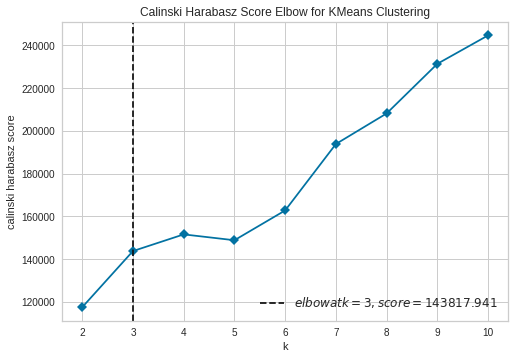

In [39]:
from yellowbrick.cluster import KElbowVisualizer
comp_star = pd.concat([compliments_feedback, df.loc[:,'average_stars']], axis=1)
model = KElbowVisualizer(KMeans(), k=10, metric='calinski_harabasz', timings=False)
model.fit(comp_star)
model.show()

**K-cluster value extraction only showed once, as repeated runs make the script run slow**

In [40]:
# Reset matplotlib parameters, changed by elbow visualizer
mpl.rcParams.update(mpl.rcParamsDefault)

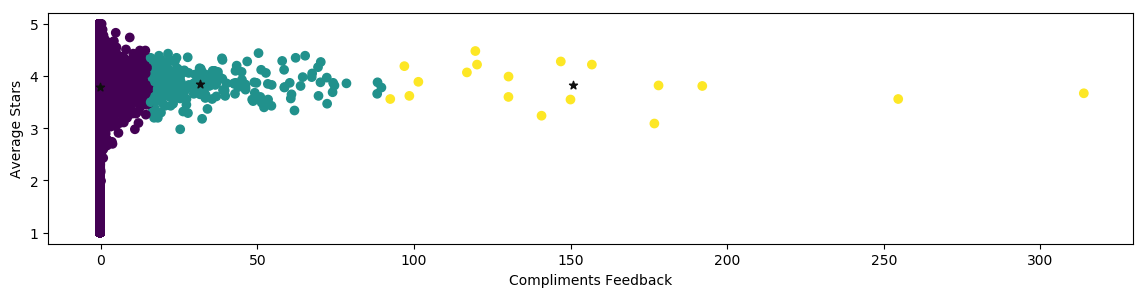

In [41]:
model = KMeans(n_clusters=3)
model.fit(comp_star)
all_predictions = model.predict(comp_star)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(comp_star.iloc[:,0].values, comp_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Compliments Feedback')
plt.ylabel('Average Stars')
plt.show()

Insight:
> Lets call each centroid/cluster, low_complimented, moderately_complimented, highly_complimented users.
> 1. low_complimented users with low count of compliments_feedback, or the leftmost centroid/cluster depict that users who get low/occasional compliments, rate across the spectrum of average ratings, but mostly staying at the center (3.5-4 avg).
> 2. moderately_complimented users, who have a higher numder of compliments, rate in a stricter margin of 3-4.5 star avg rating, with majority at 4, which means users with moderate compliments, rate more highly on average. 
> 3. highly_complimented users, are low in numbers, as opposed to others, and if we assume their sample sparsity is representative of the population, then we can say they also on average rate highly or above 4 stars in most cases, but show wider variance as opposed to moderately complimented users. 

> Using Assumption 1: That sample sparsity is represenattive of population, and Assumption 2: Normal Distribution of overall avg ratings is not accounted by Bessels Correction, we can say that if a user has moderate compliments, then we can expect them to show a tight variance of high avg ratings.

**7.2 Active Feedback (review count, elite status achieved count) vs Avg Stars Ratings**

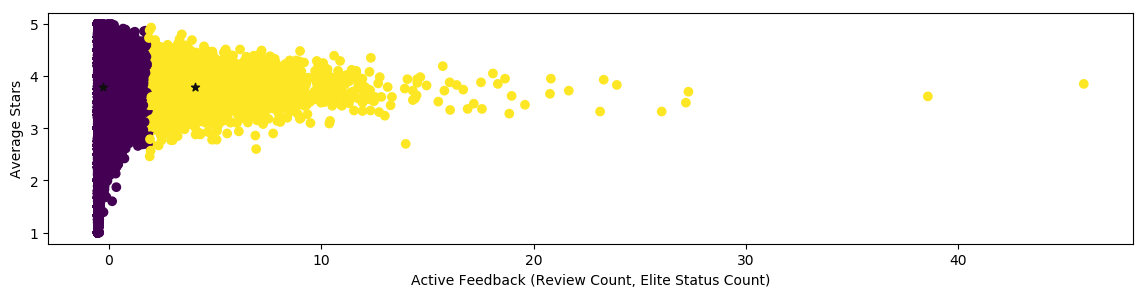

In [42]:
act_star = pd.concat([active_feedback, df.loc[:,'average_stars']], axis=1)
model = KMeans(n_clusters=2)
model.fit(act_star)
all_predictions = model.predict(act_star)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(act_star.iloc[:,0].values, act_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Active Feedback (Review Count, Elite Status Count)')
plt.ylabel('Average Stars')
plt.show()

Insight:
> Lets call each centroid/cluster, less_active, and more_active users.
> 1. less_active users with lower count of reviews and who have achieved elite status less number of times, again rate across the spectrum, and show higher variance as opposed to more_active users. The funnel of the cluster is tigher and more widely spread than more_active users. 
> 2. more_active users, or ones with higher review count and more number of elite statuses, have almost non-existent low average ratings as opposed to less-active users, and as number amount of active_feedback increases, users' averages start accumulating towards the center at 3.5-4 avg star ratings, even for a very high amount of activity >20.

> Using assumptions from 7.1, we can tentatively say (can't be sure w/o chi square, or other hypothesis testing methodologies), that if we see a yelp yser who is very active, then their average rating may fall somewhere between 3.5 - 4. It is important to note, that the normal distribution of ratings also lie at the center, so we dont want to read too much into the data, but as very high active_feedback users lie in the center, we may relatively safely say that there is a tendency for average ratings to fall at 3.5-4range, which is actually a known observation in online ratings. 

**7.3 Popularity Feedback (Friend Count, Fans Count) vs Avg Stars Ratings**

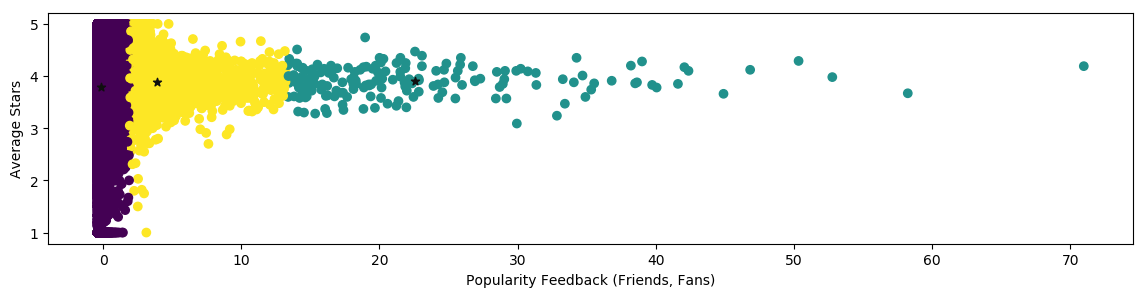

In [43]:
pop_stars = pd.concat([popularity_feedback, df.loc[:,'average_stars']], axis=1)
model = KMeans(n_clusters=3)
model.fit(pop_stars)
all_predictions = model.predict(pop_stars)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(pop_stars.iloc[:,0].values, pop_stars.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Popularity Feedback (Friends, Fans)')
plt.ylabel('Average Stars')
plt.show()

Insight:
> Lets call each centroid/cluster, less_popular, moderately_popular, paris_hilton users.
> 1. less_popular users with lower number of fans and freinds, tend to extremely uniformly rate across the spectrum, as opposed to any other user block. 
> 2. moderately_popular users, with rising popularity tend to start diverging from the behavior of less popular users. As the centroid lies smack dab in the middle, yet lower end of the popularity matrix, showing that mode_popular users also have a tendency to have avg ratings more or less across the board, but some do always vote highly (>4 or >5 are there)
> 3. paris_hilton users, who rate highly on the popularity index do not as opposed to previous 2 segments, have large high avg ratings, but lie majoritarily in the center.

> Using assumptions from 7.1, as w/o hypothesis testing, and not acoounting for the implicit central tendecy the ratings itself, we may say that if a user is less popular then they may have avg raatings across the borad, but if they are super popular then we can expect them to them have ratings in middel brackett. 

**7.4 Review Feedback (funny, cool, useful) vs Popularity Feedback (Fan Count, Friends Count)**

In [44]:
rev_pop = pd.concat([review_feedback, popularity_feedback], axis=1)
print("Correlation: {:0.02%}".format((rev_pop.corr()).iloc[0,1]))

Correlation: 73.09%


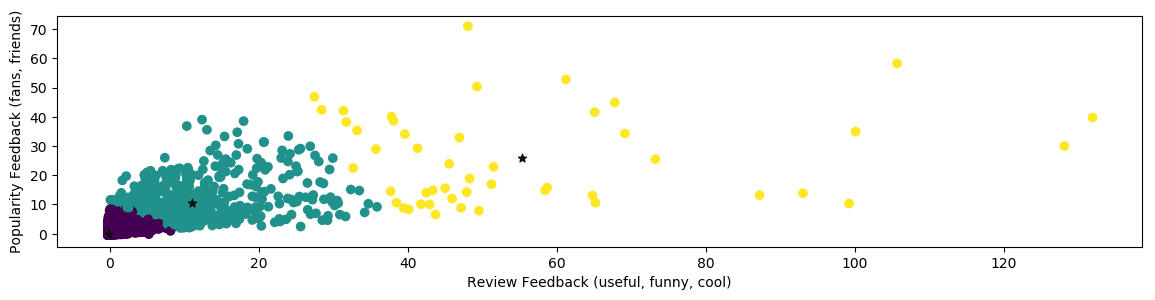

In [45]:
model = KMeans(n_clusters=3)
model.fit(rev_pop)
all_predictions = model.predict(rev_pop)
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(rev_pop.iloc[:,0].values, rev_pop.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Review Feedback (useful, funny, cool)')
plt.ylabel('Popularity Feedback (fans, friends)')
plt.show()

Insight:
> Lets call each centroid/cluster (left to right), low_target_seg, mid_target_seg, high_target_seg users.


> 1. low_target_seg users have review feedback extremely low, and as all reviews are highly correlated (~99%), we can say they have reveies tagged useful least number of times, and also score low on the popularity index. From a buisness perspective, we may consider them as last to approach for targetted advertisement via Yelp ads or in other ways.
> 2. mid_target_seg users, are moderately targettable segment, as they have some amount of reviews marked as useful, and have relatively speaking a fair amount of poularity in terms of number of fans and friends. We also show via correlation (not causation) that users with some helpful reviews have some popularity.
> 3. high_target_seg, or very useful reviewers,they have a high number of reviews that were considered useful by fellow members, and have a relatively large fan and freind following. As the user number is low, reviews usefulness is high, and popularity is also high (thereby increasing review visibility), these may be targetted by Yelp Service Providers for high volume, or high worth advertisements. 


> Keeping in mind all the assumptions mentioned in previous insights, we may say that useful or high review feedback index users have larger followings.

**7.5 Review Feedback (funny, cool, useful) vs Active Feedback (Review Count, Elite Status Count)**

In [46]:
rev_act = pd.concat([review_feedback, active_feedback], axis=1)
print("Correlation: {:0.02%}".format((rev_act.corr()).iloc[0,1]))

Correlation: 51.52%


Text(0, 0.5, 'Active Feedback (review, elite counts)')

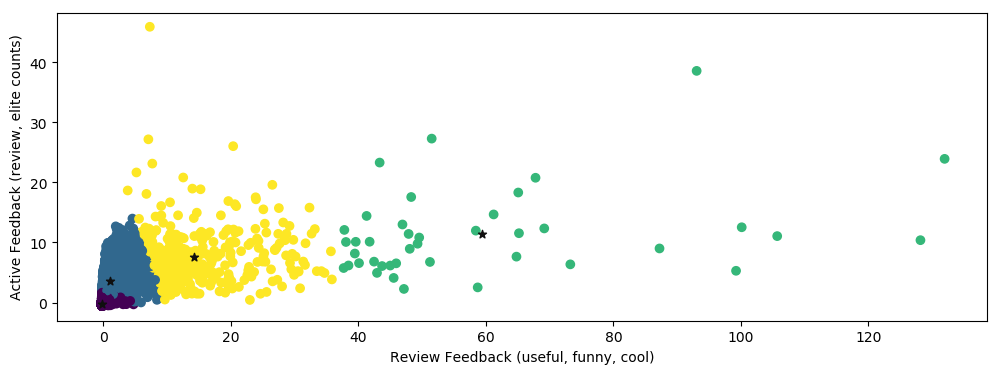

In [47]:
model = KMeans(n_clusters=4)
model.fit(rev_act)
all_predictions = model.predict(rev_act)
centroids = model.cluster_centers_

plt.figure(figsize=(12,4))
plt.scatter(rev_act.iloc[:,0].values, rev_act.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Review Feedback (useful, funny, cool)')
plt.ylabel('Active Feedback (review, elite counts)')

Insight:
> Lets call each centroid/cluster (left to right), poor_reviewers, avg_reviewers, good_reviewers, and great_reviewers.

> Correlation calculated earlier is ~50%. Important metric used in insights.

> It is interesting to see that Review Feedback is very poorly correlated with User Activity or active feedback. If we ignore, poor_reviewers clusters, which essentially just shows not active and not useful review writers, we can focus on other 3 segments. If we see the broad distribution or the centroid positions for other 3 segments we notice, that without a significant change in active feedback (more apparent in good & great reviewers), there is a rather discrenable differnce in thier review usefulness/feedback. There are many good_reviewrs who are very active but have not scored highly on review usefullness. Whereas great_reviewers with majoritarily similar spreads on active feedback (y-axis) vary in a wide range across thier usefullness in terms of writing reviews. 

> If we just consider the range of good and great reviewers on active/y_axis (which is not a good metric by itself, but highlights the low correlation), we see that good_reviewers segments have a wider range of activity metrics but perform comparitevly poor on review feedback metrics. 

> Furthermore, in just the great_reviewers spread on review/x-axis, similar levels of "activity" also produces wast amounts of varying review usefullness (or greatness?). Since, Review Feedback consists of highly correlated review_useful_count and Active Feedback also consists of correlated review_count feature, one might further (an untested, non Hypothesis verified, bead on sample data) statement that greatness (review usefulness) has alsmot little to do with number of reviews one writes.

Interesting Aside: Could one misquote Shakespeare and say chance of (being born great, having geatness thrust upon them) > ability to achieve greatness? 

*--- End ---*